# Load Dependencies

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem,Descriptors
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from baseline.script_baseline.descriptor import get_acsf_dict,GetRdkitDescriptorsdict,get_fp_dict,get_oh,des_std
from baseline.script_baseline.model import  models
from baseline.script_baseline.model import RandomForest,GradientBoosting
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [3]:
data_file = '../Data/data2/data2.csv'
tmp_df = pd.read_csv(data_file)
cat_smiles = np.array(tmp_df['Catalyst'].to_list())
imine_smiles =  np.array(tmp_df['Imine'].to_list())
thiol_smiles =  np.array(tmp_df['Thiol'].to_list())
labels = np.array(tmp_df['Output'].to_list())
labels_std = (labels - labels.min())/(labels.max()-labels.min())
cat_smi_set = list(set(cat_smiles))
imine_smi_set = list(set(imine_smiles))
thiol_smi_set = list(set(thiol_smiles))
cat_smi_set.sort()
imine_smi_set.sort()
thiol_smi_set.sort()

In [4]:
blind_test_data=pd.read_csv('./data/data2_blind_test.csv')
test_thiol_smiles = np.array(blind_test_data['test_thiol'].to_list())
test_imine_smiles = np.array(blind_test_data['test_imine'].to_list())
test_cat_smiles = np.array(blind_test_data['cat_smi_set'].to_list())

test_thiol_smiles_set=set(test_thiol_smiles)
test_imine_smiles_set=set(test_imine_smiles)
test_cat_smiles_set=set(test_cat_smiles)

# Show Test Acids

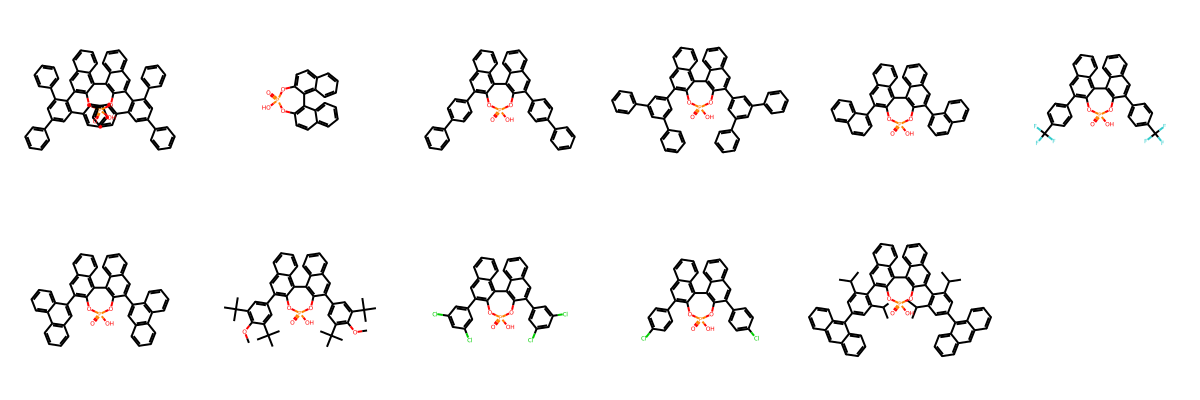

In [5]:
mol=[]
for i in test_cat_smiles:
    mol.append(Chem.MolFromSmiles(i)) 
from rdkit.Chem import Draw
img = Draw.MolsToGridImage(mol,molsPerRow=6,subImgSize=(200,200),legends=['' for x in mol])
img  

# Generate Descriptor

In [6]:
rdkit_cat_all_dict = GetRdkitDescriptorsdict(cat_smi_set)
rdkit_imine_all_dict= GetRdkitDescriptorsdict(imine_smi_set)
rdkit_thiol_all_dict =GetRdkitDescriptorsdict(thiol_smi_set)

fp_cat_all_dict = get_fp_dict(cat_smi_set)
fp_imine_all_dict= get_fp_dict(imine_smi_set)
fp_thiol_all_dict =get_fp_dict(thiol_smi_set)

species=['N', 'H', 'C', 'P',"F","Cl","Br","O","I","S","Si"]
acsf_cat_all_dict = get_acsf_dict(cat_smi_set,species=species)
acsf_imine_all_dict= get_acsf_dict(imine_smi_set,species=species)
acsf_thiol_all_dict =get_acsf_dict(thiol_smi_set,species=species)

test_acsf_cat_all_dict = get_acsf_dict(test_cat_smiles,species=species)
test_rdkit_cat_all_dict = GetRdkitDescriptorsdict(test_cat_smiles)
test_fp_cat_all_dict = get_fp_dict(test_cat_smiles)

[22:42:34] UFFTYPER: Unrecognized atom type: S_6+6 (10)
[22:42:34] UFFTYPER: Unrecognized atom type: S_6+6 (34)
[22:42:55] UFFTYPER: Unrecognized atom type: S_6+6 (10)
[22:42:55] UFFTYPER: Unrecognized atom type: S_6+6 (34)
[22:42:55] UFFTYPER: Unrecognized atom type: S_6+6 (10)
[22:42:55] UFFTYPER: Unrecognized atom type: S_6+6 (34)


In [7]:
train_number=1075
acsf_total_cat = np.array([[acsf_cat_all_dict[tmp_smi]] for tmp_smi in cat_smiles]).reshape(train_number,-1)
acsf_total_imine = np.array([[acsf_imine_all_dict[tmp_smi]] for tmp_smi in imine_smiles]).reshape(train_number,-1)
acsf_total_thiol = np.array([[acsf_thiol_all_dict[tmp_smi]] for tmp_smi in thiol_smiles]).reshape(train_number,-1)
acsf_react_feat = np.concatenate([acsf_total_cat,acsf_total_imine,acsf_total_thiol],axis = 1)

rdkit_total_cat = np.array([[rdkit_cat_all_dict[tmp_smi]] for tmp_smi in cat_smiles]).reshape(train_number,-1)
rdkit_total_imine = np.array([[rdkit_imine_all_dict[tmp_smi]] for tmp_smi in imine_smiles]).reshape(train_number,-1)
rdkit_total_thiol = np.array([[rdkit_thiol_all_dict[tmp_smi]] for tmp_smi in thiol_smiles]).reshape(train_number,-1)
rdkit_react_feat = np.concatenate([rdkit_total_cat,rdkit_total_imine,rdkit_total_thiol],axis = 1)

fp_total_cat = np.array([[fp_cat_all_dict[tmp_smi]] for tmp_smi in cat_smiles]).reshape(train_number,-1)
fp_total_imine = np.array([[fp_imine_all_dict[tmp_smi]] for tmp_smi in imine_smiles]).reshape(train_number,-1)
fp_total_thiol = np.array([[fp_thiol_all_dict[tmp_smi]] for tmp_smi in thiol_smiles]).reshape(train_number,-1)
fp_react_feat = np.concatenate([fp_total_cat,fp_total_imine,fp_total_thiol],axis = 1)

In [8]:
blind_num=11

test_acsf_total_cat = np.array([[test_acsf_cat_all_dict[tmp_smi]] for tmp_smi in test_cat_smiles]).reshape(blind_num,-1)
test_acsf_total_imine = np.array([[acsf_imine_all_dict[tmp_smi]] for tmp_smi in test_imine_smiles]).reshape(blind_num,-1)
test_acsf_total_thiol = np.array([[acsf_thiol_all_dict[tmp_smi]] for tmp_smi in test_thiol_smiles]).reshape(blind_num,-1)
test_acsf_react_feat = np.concatenate([test_acsf_total_cat,test_acsf_total_imine,test_acsf_total_thiol],axis = 1)
all_acsf_des =  np.concatenate([test_acsf_react_feat,acsf_react_feat],axis = 0)
all_acsf_des_std = des_std(all_acsf_des)
test_acsf_react_feat_std=all_acsf_des_std[:11]
acsf_react_feat_std = all_acsf_des_std[11:]

test_rdkit_total_cat = np.array([[test_rdkit_cat_all_dict[tmp_smi]] for tmp_smi in test_cat_smiles]).reshape(blind_num,-1)
test_rdkit_total_imine = np.array([[rdkit_imine_all_dict[tmp_smi]] for tmp_smi in test_imine_smiles]).reshape(blind_num,-1)
test_rdkit_total_thiol = np.array([[rdkit_thiol_all_dict[tmp_smi]] for tmp_smi in test_thiol_smiles]).reshape(blind_num,-1)
test_rdkit_react_feat = np.concatenate([test_rdkit_total_cat,test_rdkit_total_imine,test_rdkit_total_thiol],axis = 1)
all_rdkit_des =  np.concatenate([test_rdkit_react_feat,rdkit_react_feat],axis = 0)
all_rdkit_des_std = des_std(all_rdkit_des)
test_rdkit_react_feat_std=all_rdkit_des_std[:11]
rdkit_react_feat_std = all_rdkit_des_std[11:]

test_fp_total_cat = np.array([[test_fp_cat_all_dict[tmp_smi]] for tmp_smi in test_cat_smiles]).reshape(blind_num,-1)
test_fp_total_imine = np.array([[fp_imine_all_dict[tmp_smi]] for tmp_smi in test_imine_smiles]).reshape(blind_num,-1)
test_fp_total_thiol = np.array([[fp_thiol_all_dict[tmp_smi]] for tmp_smi in test_thiol_smiles]).reshape(blind_num,-1)
test_fp_react_feat = np.concatenate([test_fp_total_cat,test_fp_total_imine,test_fp_total_thiol],axis = 1)
all_fp_des =  np.concatenate([test_fp_react_feat,fp_react_feat],axis = 0)
all_fp_des_std = des_std(all_fp_des)
test_fp_react_feat_std=all_fp_des_std[:11]
fp_react_feat_std = all_fp_des_std[11:]

# External Experimental Tests

In [10]:
descs = [rdkit_react_feat_std,fp_react_feat_std,acsf_react_feat_std]
test_descs = [test_rdkit_react_feat_std,test_fp_react_feat_std,test_acsf_react_feat_std]
y_test=np.array([0.840 , 0.083, 0.667, 0.767, 0.919, 0.651, 0.982, 0.683, 0.733,0.516, 1.153])
labels_ddg=labels*0.693
labels_ddg_std=(labels_ddg-np.min(labels_ddg))/(np.max(labels_ddg)-np.min(labels_ddg))
y_test_std=(y_test-np.min(labels_ddg))/(np.max(labels_ddg)-np.min(labels_ddg))

In [11]:
rdkit_opt_model= GradientBoostingRegressor(n_estimators=150,max_depth=3)
fp_opt_model=GradientBoostingRegressor(n_estimators=50,max_depth=5)
acsf_opt_model=GradientBoostingRegressor(n_estimators=300,max_depth=3)

In [19]:
number=20
      
desc=descs[0]
test_desc=test_descs[0]
model=rdkit_opt_model
repeat_pred1 = []
repeat_test1 = []
for i in range(number):
    train_x,test_x = desc,test_desc
    train_y,test_y = labels_ddg_std,y_test_std
    model.fit(train_x,train_y)
    test_pred = model.predict(test_x)
    repeat_pred1.append(test_pred)
    repeat_test1.append(test_y)
repeat_pred1=np.mean(repeat_pred1,axis=0)*(np.max(labels_ddg)-np.min(labels_ddg))+np.min(labels_ddg)
repeat_test1=np.mean(repeat_test1,axis=0)*(np.max(labels_ddg)-np.min(labels_ddg))+np.min(labels_ddg)
r2_1=r2_score(repeat_test1,repeat_pred1)
rmse1=(mean_squared_error(repeat_test1,repeat_pred1))**(0.5)
mae1=mean_absolute_error(repeat_test1,repeat_pred1)
print('---------------------------------RDKit descriptor------------------------------------',
      'r2_1:',r2_1 , '\n RMSE:',np.round(rmse1,3),'MAE:',np.round(mae1,3),'\n Predicted value:',np.round(repeat_pred1,3),'\n')

desc=descs[1]
test_desc=test_descs[1]
model=fp_opt_model
repeat_pred2 = []
repeat_test2 = []
for i in range(number):
    train_x,test_x = desc,test_desc
    train_y,test_y = labels_ddg_std,y_test_std
    model.fit(train_x,train_y)
    test_pred = model.predict(test_x)
    repeat_pred2.append(test_pred)
    repeat_test2.append(test_y)
repeat_pred2=np.mean(repeat_pred2,axis=0)*(np.max(labels_ddg)-np.min(labels_ddg))+np.min(labels_ddg)
repeat_test2=np.mean(repeat_test2,axis=0)*(np.max(labels_ddg)-np.min(labels_ddg))+np.min(labels_ddg)
r2_2=r2_score(repeat_test2,repeat_pred2)
rmse2=(mean_squared_error(repeat_test2,repeat_pred2))**(0.5)
mae2=mean_absolute_error(repeat_test2,repeat_pred2)
print('--------------------------------Morgan Fingerprint-----------------------------------',
       'r2_2:',r2_2 ,'\n RMSE:',np.round(rmse2,3),'MAE:',np.round(mae2,3),'\n Predicted value:',np.round(repeat_pred2,3),'\n')

desc=descs[2]
test_desc=test_descs[2]
model=acsf_opt_model
repeat_pred3 = []
repeat_test3 = []
for i in range(number):
    train_x,test_x = desc,test_desc
    train_y,test_y = labels_ddg_std,y_test_std
    model.fit(train_x,train_y)
    test_pred = model.predict(test_x)
    repeat_pred3.append(test_pred)
    repeat_test3.append(test_y)
repeat_pred3=np.mean(repeat_pred3,axis=0)*(np.max(labels_ddg)-np.min(labels_ddg))+np.min(labels_ddg)
repeat_test3=np.mean(repeat_test3,axis=0)*(np.max(labels_ddg)-np.min(labels_ddg))+np.min(labels_ddg)
r2_3=r2_score(repeat_test3,repeat_pred3)
rmse3=(mean_squared_error(repeat_test3,repeat_pred3))**(0.5)
mae3=mean_absolute_error(repeat_test3,repeat_pred3)
print('--------------------------------------ACSFs---------------------------------------',
       'r2_3:',r2_3 ,'\n RMSE:',np.round(rmse3,3),'MAE:',np.round(mae3,3),'\n Predicted value:',np.round(repeat_pred3,3),'\n')

repeat_pred4=np.array([1.05, 0.77, 0.71, 0.72, 0.8 , 0.75, 0.76, 0.83, 0.49, 0.56, 0.29])
repeat_test4=np.array([1.15, 0.98, 0.92, 0.84, 0.77, 0.73, 0.68, 0.67, 0.65, 0.52, 0.08])
r2_4=r2_score(repeat_test4,repeat_pred4)
rmse4=(mean_squared_error(repeat_test4,repeat_pred4))**(0.5)
mae4=mean_absolute_error(repeat_test4,repeat_pred4)
print('-----------------------------------SEMG/MIGNN-------------------------------------',
       'r2_4:',r2_4 ,'\n RMSE:',np.round(rmse4,3),'MAE:',np.round(mae4,3),'\n Predicted value:',np.round(repeat_pred4,3),'\n')

---------------------------------RDKit descriptor------------------------------------ r2_1: -0.9956863725834553 
 RMSE: 0.373 MAE: 0.299 
 Predicted value: [1.709 0.41  0.868 0.839 1.073 0.827 1.1   0.969 0.896 0.867 1.723] 

--------------------------------Morgan Fingerprint----------------------------------- r2_2: -0.13197844353108423 
 RMSE: 0.281 MAE: 0.22 
 Predicted value: [1.333 0.241 0.815 0.895 1.021 0.81  0.992 0.857 0.85  0.82  1.779] 

--------------------------------------ACSFs--------------------------------------- r2_3: -1.810584465170539 
 RMSE: 0.443 MAE: 0.349 
 Predicted value: [1.725 0.316 0.943 1.543 0.857 0.851 0.858 0.799 0.932 0.827 1.812] 

-----------------------------------SEMG/MIGNN------------------------------------- r2_4: 0.7170602306908884 
 RMSE: 0.141 MAE: 0.122 
 Predicted value: [1.05 0.77 0.71 0.72 0.8  0.75 0.76 0.83 0.49 0.56 0.29] 



# Show Results

Text(0.5, 0, 'Absolute Error of Prediction (kcal/mol)')

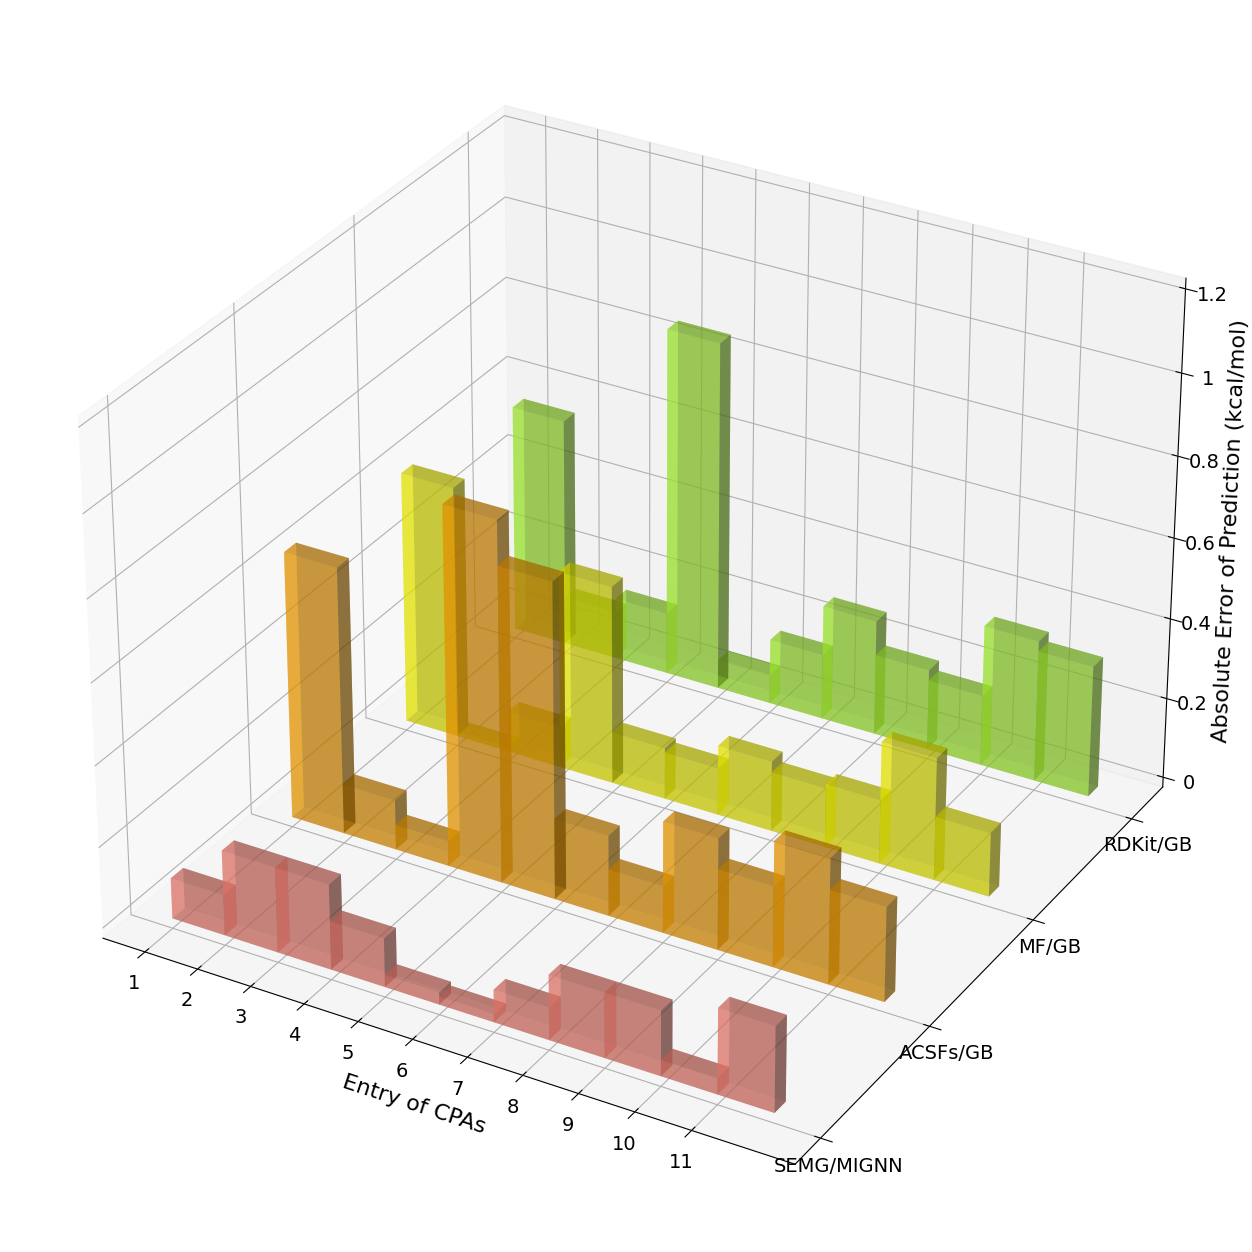

In [20]:
label_size = 16
tick_size = 14
title_fontsize = 18
fig = plt.figure(figsize=(20, 16))
ax1 = fig.add_subplot(111, projection='3d')

dev_1  =(repeat_pred1-np.array(repeat_test1))
dev_2  =(repeat_pred2-np.array(repeat_test2))
dev_3  =(repeat_pred3-np.array(repeat_test3))
dev_4  =(repeat_pred4-np.array(repeat_test4))

dev_1  =np.array(sorted([[a,e] for a,e in zip(dev_1,repeat_test1)],key=lambda x:x[1],reverse=True))[:,0]
dev_2  =np.array(sorted([[a,e] for a,e in zip(dev_2,repeat_test2)],key=lambda x:x[1],reverse=True))[:,0]
dev_3  =np.array(sorted([[a,e] for a,e in zip(dev_3,repeat_test3)],key=lambda x:x[1],reverse=True))[:,0]
dev_4  =np.array(sorted([[a,e] for a,e in zip(dev_4,repeat_test4)],key=lambda x:x[1],reverse=True))[:,0]


x = list(range(len(dev_1)))
lang=1
alpha=0.5

ax1.bar3d(x,np.zeros(len(x))+lang*3,np.zeros(len(x)),1,0.1,np.abs(dev_1),shade=True,color='greenyellow',alpha=alpha)
ax1.bar3d(x,np.zeros(len(x))+lang*2,np.zeros(len(x)),1,0.1,np.abs(dev_2), shade=True,color='yellow',alpha=alpha)
ax1.bar3d(x,np.zeros(len(x))+lang*1,np.zeros(len(x)),1,0.1,np.abs(dev_3),shade=True,color='orange',alpha=alpha)
ax1.bar3d(x,np.zeros(len(x))+lang*0,np.zeros(len(x)),1,0.1,np.abs(dev_4), shade=True,color='salmon',alpha=alpha)
ax1.set_xticks(list(range(11)))
ax1.set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11'],fontsize=tick_size)

ax1.set_yticks([0,lang,lang*2,lang*3])
ax1.set_yticklabels(['SEMG/MIGNN','ACSFs/GB','MF/GB','RDKit/GB'],fontsize=tick_size)

ax1.set_zticks([0,0.2,0.4,0.6,0.8,1.0,1.2])
ax1.set_zticklabels(['0','0.2','0.4','0.6','0.8','1','1.2'],fontsize=tick_size)
ax1.set_xlabel('Entry of CPAs',fontsize=label_size,labelpad=8)
ax1.set_zlabel('Absolute Error of Prediction (kcal/mol)',fontsize=label_size)

In [21]:
np.save('./dataset/repeat_pred1.npy',repeat_pred1)
np.save('./dataset/repeat_pred2.npy',repeat_pred2)
np.save('./dataset/repeat_pred3.npy',repeat_pred3)
np.save('./dataset/repeat_pred4.npy',repeat_pred4)

np.save('./dataset/repeat_test1.npy',repeat_test1)
np.save('./dataset/repeat_test2.npy',repeat_test2)
np.save('./dataset/repeat_test3.npy',repeat_test3)
np.save('./dataset/repeat_test4.npy',repeat_test4)

# Sort Acids as  Experimental DDG

## RDKit/GB

In [22]:
np.round(np.array(sorted([[a,e] for a,e in zip(repeat_pred1,repeat_test1)],key=lambda x:x[1],reverse=True))[:,0],2)

array([1.72, 1.1 , 1.07, 1.71, 0.84, 0.9 , 0.97, 0.87, 0.83, 0.87, 0.41])

## MF/GB

In [23]:
np.round(np.array(sorted([[a,e] for a,e in zip(repeat_pred2,repeat_test2)],key=lambda x:x[1],reverse=True))[:,0],2)

array([1.78, 0.99, 1.02, 1.33, 0.9 , 0.85, 0.86, 0.82, 0.81, 0.82, 0.24])

## ACSFs/GB

In [24]:
np.round(np.array(sorted([[a,e] for a,e in zip(repeat_pred3,repeat_test3)],key=lambda x:x[1],reverse=True))[:,0],2)

array([1.81, 0.86, 0.86, 1.73, 1.54, 0.93, 0.8 , 0.94, 0.85, 0.83, 0.32])

## SEMG/MIGNN

In [25]:
np.round(np.array(sorted([[a,e] for a,e in zip(repeat_pred4,repeat_test4)],key=lambda x:x[1],reverse=True))[:,0],2)

array([1.05, 0.77, 0.71, 0.72, 0.8 , 0.75, 0.76, 0.83, 0.49, 0.56, 0.29])

# Comparation with SOTA Models in External Test

In [27]:
acsf=np.array([1.81, 0.86, 0.86, 1.73, 1.54, 0.93, 0.8 , 0.94, 0.85, 0.83, 0.32]) 
mff=np.array([1.88, 1.04, 1.  , 1.28, 0.88, 0.89, 0.88, 1.31, 0.84, 0.86, 0.28])
drfp=np.array([1.83, 1.18, 1.5 , 1.44, 1.36, 1.15, 1.15, 1.34, 1.36, 1.37, 1.15])
semg=np.array([1.05, 0.77, 0.71, 0.72, 0.8 , 0.75, 0.76, 0.83, 0.49, 0.56, 0.29])
exp=[1.15, 0.98, 0.92, 0.84, 0.77, 0.73, 0.68, 0.67, 0.65, 0.52, 0.08]

Text(0.5, 0, 'Absolute Error of Prediction (kcal/mol)')

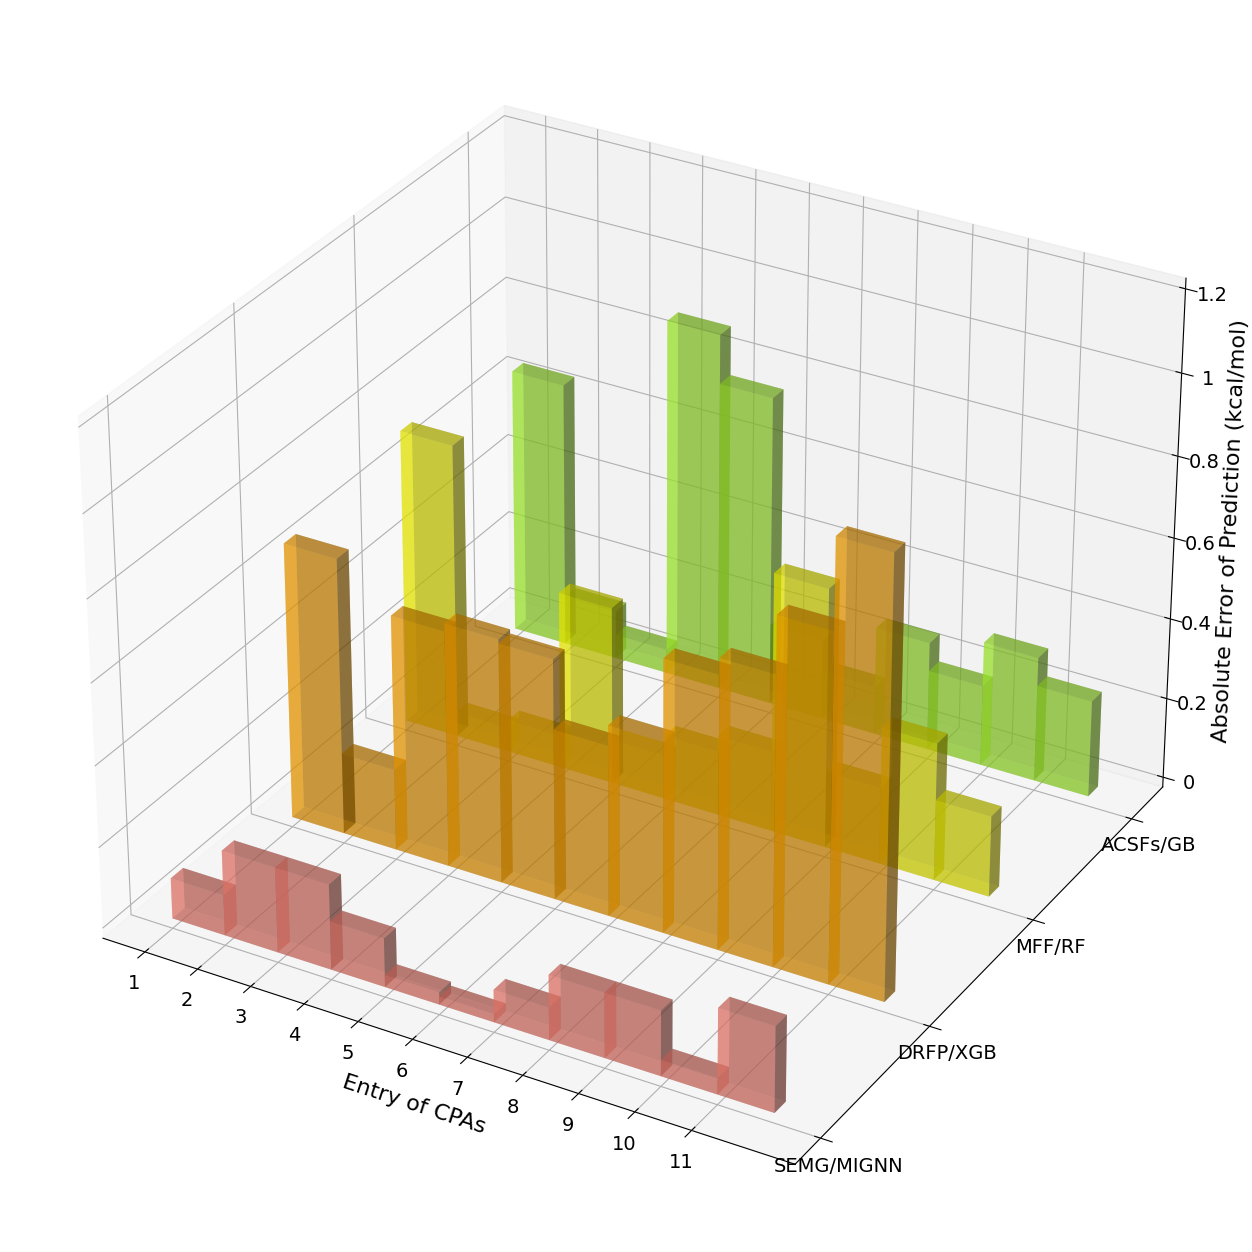

In [28]:
import matplotlib.pyplot as plt
label_size = 16
tick_size = 14
title_fontsize = 18
fig = plt.figure(figsize=(20, 16))
ax1 = fig.add_subplot(111, projection='3d')

dev_1  =(acsf-np.array(exp))
dev_2  =(mff-np.array(exp))
dev_3  =(drfp-np.array(exp))
dev_4  =(semg-np.array(exp))

dev_1  =np.array(sorted([[a,e] for a,e in zip(dev_1,exp)],key=lambda x:x[1],reverse=True))[:,0]
dev_2  =np.array(sorted([[a,e] for a,e in zip(dev_2,exp)],key=lambda x:x[1],reverse=True))[:,0]
dev_3  =np.array(sorted([[a,e] for a,e in zip(dev_3,exp)],key=lambda x:x[1],reverse=True))[:,0]
dev_4  =np.array(sorted([[a,e] for a,e in zip(dev_4,exp)],key=lambda x:x[1],reverse=True))[:,0]


x = list(range(len(dev_1)))
lang=1
alpha=0.5

ax1.bar3d(x,np.zeros(len(x))+lang*3,np.zeros(len(x)),1,0.1,np.abs(dev_1),shade=True,color='greenyellow',alpha=alpha)
ax1.bar3d(x,np.zeros(len(x))+lang*2,np.zeros(len(x)),1,0.1,np.abs(dev_2), shade=True,color='yellow',alpha=alpha)
ax1.bar3d(x,np.zeros(len(x))+lang*1,np.zeros(len(x)),1,0.1,np.abs(dev_3),shade=True,color='orange',alpha=alpha)
ax1.bar3d(x,np.zeros(len(x))+lang*0,np.zeros(len(x)),1,0.1,np.abs(dev_4), shade=True,color='salmon',alpha=alpha)
ax1.set_xticks(list(range(11)))
ax1.set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11'],fontsize=tick_size)

ax1.set_yticks([0,lang,lang*2,lang*3])
ax1.set_yticklabels(['SEMG/MIGNN','DRFP/XGB','MFF/RF','ACSFs/GB'],fontsize=tick_size)

ax1.set_zticks([0,0.2,0.4,0.6,0.8,1.0,1.2])
ax1.set_zticklabels(['0','0.2','0.4','0.6','0.8','1','1.2'],fontsize=tick_size)
ax1.set_xlabel('Entry of CPAs',fontsize=label_size,labelpad=8)
ax1.set_zlabel('Absolute Error of Prediction (kcal/mol)',fontsize=label_size)